# Storing skymaps

## Read raw skymap files

In [ ]:
import pickle
from pathlib import Path
import math

In [2]:
home_dir = "/sdf/home/o/olynn/"
raw_skymaps_dir = Path(home_dir, "skymap-to-poly-coords", "tests", "data", "raw-skymaps")

skymap_path = raw_skymaps_dir / "skyMap_lsst_cells_v1_skymaps.pickle"
with open(skymap_path, "rb") as f:
    lsst_skymap = pickle.load(f)
lsst_skymap

## Util: check if a point is in a tract (using lsst.skymap)

In [88]:
from lsst.sphgeom import Box, ConvexPolygon, UnitVector3d

def box_to_convex_polygon(box: Box) -> ConvexPolygon:
    if box.isEmpty():
        raise ValueError("Cannot convert an empty Box to a ConvexPolygon.")

    # Get the corners of the box
    lon_a, lon_b = box.getLon().getA().asRadians(), box.getLon().getB().asRadians()
    lon_min = min(lon_a, lon_b)
    lon_max = max(lon_a, lon_b)
    lat_a, lat_b = box.getLat().getA().asRadians(), box.getLat().getB().asRadians()
    lat_min = min(lat_a, lat_b)
    lat_max = max(lat_a, lat_b)

    #print(f"Box corners: lon_min={lon_min}, lon_max={lon_max}, lat_min={lat_min}, lat_max={lat_max}")

    bottom_left = LonLat.fromRadians(lon_min, lat_min)
    bottom_right = LonLat.fromRadians(lon_max, lat_min)
    top_right = LonLat.fromRadians(lon_max, lat_max)
    top_left = LonLat.fromRadians(lon_min, lat_max)

    # Convert corners to UnitVector3d
    vertices = [
        UnitVector3d(bottom_left),
        UnitVector3d(bottom_right),
        UnitVector3d(top_right),
        UnitVector3d(top_left),
    ]

    # Create and return the ConvexPolygon
    return ConvexPolygon(vertices)


In [86]:
from math import pi
from lsst.sphgeom import LonLat, UnitVector3d, ConvexPolygon
import lsst.geom as geom


def get_poly_from_tract_id(tract_id, inner=False) -> ConvexPolygon:
    tract = lsst_skymap.generateTract(tract_id)
    if inner:
        res = tract.inner_sky_region
    else:
        res = tract.outer_sky_polygon
    if isinstance(res, Box):
        res = box_to_convex_polygon(res)
    return res

def point_in_poly(polygon, ra_degrees, dec_degrees):
    vec = UnitVector3d(LonLat.fromDegrees(ra_degrees, dec_degrees))
    return polygon.contains(vec)


    
#check_point(1, 0.0, -88.0, inner=False)
poly = get_poly_from_tract_id(1)
point_in_poly(poly, 0.0, -88.0)

True

In [84]:
def polys_are_equiv(poly_a, poly_b):
    """Check if two ConvexPolygons are equivalent."""
    verts_a = poly_a.getVertices()
    verts_b = poly_b.getVertices()

    # If they have different numbers of vertices, they can't be equivalent.
    if len(verts_a) != len(verts_b):
        return False

    # Check if vertices match in any rotation.
    for i in range(len(verts_a)):
        if all(
            verts_a[(i + j) % len(verts_a)] == verts_b[j]
            for j in range(len(verts_b))
        ):
            return True

    # If no rotation matched, they are not equivalent.
    return False

#### Optional plotting

In [16]:
import matplotlib.pyplot as plt
from lsst.sphgeom import LonLat, UnitVector3d

def plot_tract_with_point(tract_id, ra_deg, dec_deg, title=""):
    """Plot a ConvexPolygon tract and a test RA/Dec point on the sky.

    Parameters
    ----------
    polygon : sphgeom.ConvexPolygon
        The outer or inner polygon to plot.
    ra_deg : float
        Right Ascension of the test point (degrees).
    dec_deg : float
        Declination of the test point (degrees).
    title : str
        Optional title for the plot.
    """
    # Extract polygon vertices in degrees
    tract = lsst_skymap.generateTract(tract_id)
    vertex_coords = tract._vertexCoordList
    ra_dec_vertices = [
        (vertex_coord.getLongitude().asDegrees(), vertex_coord.getLatitude().asDegrees())
        for vertex_coord in vertex_coords
    ]

    # Close the polygon loop
    ra_dec_vertices.append(ra_dec_vertices[0])
    ra_poly, dec_poly = zip(*ra_dec_vertices)

    # Wrap RA into [-180, 180] for sky-style plotting
    ra_poly_wrapped = [(ra + 180) % 360 - 180 for ra in ra_poly]
    ra_pt_wrapped = (ra_deg + 180) % 360 - 180

    # Check containment
    pt_vec = UnitVector3d(LonLat.fromDegrees(ra_deg, dec_deg))
    is_inside = tract.outer_sky_polygon.contains(pt_vec)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.plot(ra_poly_wrapped, dec_poly, marker='o', linestyle='-', label="Tract Boundary")
    plt.scatter(ra_pt_wrapped, dec_deg, color="red" if not is_inside else "green", label="Test Point", zorder=5)

    plt.xlabel("RA [deg] (wrapped to [-180, 180])")
    plt.ylabel("Dec [deg]")
    plt.title(title or f"Point is {'inside' if is_inside else 'outside'} the tract")
    plt.gca().invert_xaxis()  # Sky convention
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


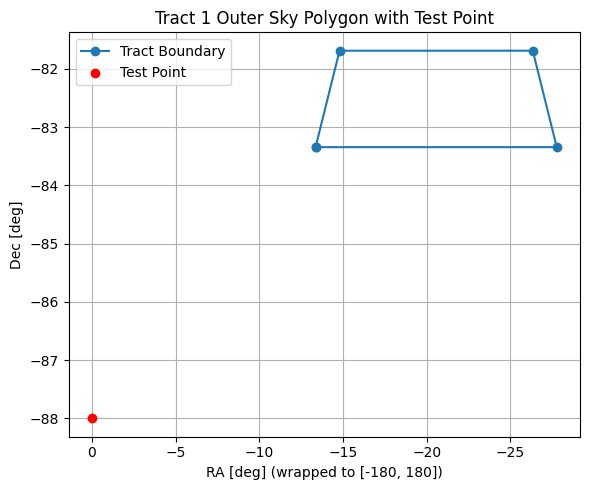

In [20]:
plot_tract_with_point(
    111,
    ra_deg=0.0,
    dec_deg=-88.0,
    title="Tract 1 Outer Sky Polygon with Test Point"
)

*A note on rings sky map pixelization (in html comment in this cell)*
<!---## Rings sky map pixelization
*From the RingsSkyMap docstring in lsst.skymap:*

We divide the sphere into N rings of Declination, plus the two polar
caps, which sets the size of the individual tracts.  The rings are
divided in RA into an integral number of tracts of this size; this
division is made at the Declination closest to zero so as to ensure
full overlap.

Rings are numbered in the rings from south to north. The south pole cap is
``tract=0``, then the tract at ``raStart`` in the southernmost ring is
``tract=1``. Numbering continues (in the positive RA direction) around that
ring and then continues in the same fashion with the next ring north, and
so on until all reaching the north pole cap, which is
``tract=len(skymap) - 1``.

However, ``version=0`` had a bug in the numbering of the tracts: the first
and last tracts in the first (southernmost) ring were identical, and the
first tract in the last (northernmost) ring was missing. When using
``version=0``, these tracts remain missing in order to preserve the
numbering scheme.--->

## Storage options


We would like to support both inner and outer polygons for the tracts.  

Tracts are arranged in "rings", which span horizontal regions of the sky.

🔹 Inner polys:
- represent the exact boundaries of a given tract
- do not overlap

🔹 Outer polys:
- may (will?) overlap with adjacent tracts' outer polys
- are akin to margins in HATS catalogs
- will share the same upper and lower declination boundaries as the other tracts in the ring

## Option 1: Two files, explicit inner polys + reconstructable outer polys

#### Inner polys:
- Store per-tract: `ra_min`, `ra_max`, `dec_min`, `dec_max`
- Comes directly from `getRaDecRange(tract_index)`
- Requires 4 floats per tract, so for ~19k tracts:
  4 × 8 B × 19,000 ≈ ~600 KB (before YAML overhead; ~1–1.5 MB total)
- However, could compress to a `.npz` of around ~0.5–0.8 MB

#### Outer polys:

#### ✅ Pros
- Easy to understand and verify
- Doesn’t require any LSST WCS machinery
- Reading is fast + LSST-free

#### ❌ Cons
- Slightly more disk usage than an ultra-compressed model

### Write inner_poly and outer_poly files

In [138]:
import yaml
from lsst.sphgeom import UnitVector3d

def write_polygons(skymap, output_path, inner=True):
    """Write exact inner polygons for each tract using 3D unit vectors.

    Parameters
    ----------
    skymap : RingsSkyMap
        The LSST SkyMap object.
    output_path : str
        Path to output YAML file.
    inner : bool
        If True, write inner polygons; if False, write outer polygons.
        Default is True.
    """
    out = {"tracts": {}}

    for tract in skymap:
        tract_id = tract.getId()
        if inner:
            poly = tract.inner_sky_region
            if isinstance(poly, Box):
                poly = box_to_convex_polygon(poly)
        else:
            poly = tract.outer_sky_polygon

        out["tracts"][tract_id] = [
            [v[0], v[1], v[2]] for v in poly.getVertices()
        ]

    with open(output_path, "w") as f:
        yaml.dump(out, f, sort_keys=False)

    polygon_type = "Inner" if inner else "Outer"
    print(f"✅ {polygon_type} polygons written to {output_path}")


In [139]:
skymap_out_dir = "/sdf/home/o/olynn/skymap-to-poly-coords/skymaps_out/"
inner_poly_path = Path(skymap_out_dir) / "inner_polys.yaml"
outer_poly_path = Path(skymap_out_dir) / "outer_polys.yaml"

write_polygons(lsst_skymap, inner_poly_path, inner=True)
#write_outer_polygons(lsst_skymap, outer_poly_path)

✅ Inner polygons written to /sdf/home/o/olynn/skymap-to-poly-coords/skymaps_out/inner_polys.yaml


### Read inner_poly

In [144]:
import yaml
from lsst.sphgeom import UnitVector3d, ConvexPolygon

def load_polygons(yaml_path):
    """Load exact inner or outer polygons from a YAML file using 3D unit vectors.

    Parameters
    ----------
    yaml_path : str
        Path to the YAML file written by `write_polygons`.

    Returns
    -------
    dict
        Mapping from tract ID (int) to sphgeom.ConvexPolygon.
    """
    with open(yaml_path, "r") as f:
        data = yaml.safe_load(f)

    poly_dict = {}

    for tract_id_str, vec_list in data["tracts"].items():
        tract_id = int(tract_id_str)

        unit_vecs = [UnitVector3d(*vec) for vec in vec_list]

        # Skip degenerate polygons (fewer than 3 unique vertices)
        unique_vecs = {tuple(round(x, 12) for x in v) for v in unit_vecs}
        if len(unique_vecs) < 3:
            print(f"⚠️ Skipping degenerate tract {tract_id}")
            continue

        poly = ConvexPolygon(unit_vecs)
        poly_dict[tract_id] = poly

    return poly_dict


In [145]:
inner_poly_map = load_polygons(inner_poly_path)

⚠️ Skipping degenerate tract 0
⚠️ Skipping degenerate tract 18937


In [147]:
# Just patch the polar caps in for now (todo)
inner_poly_map[0] = get_poly_from_tract_id(0, inner=True)
inner_poly_map[18937] = get_poly_from_tract_id(18937, inner=True)

In [169]:
import numpy as np

def polys_are_equiv(poly_a, poly_b, rtol=1e-12, atol=1e-14):
    """Check if two ConvexPolygons are equivalent within floating point tolerance.

    Parameters
    ----------
    poly_a, poly_b : sphgeom.ConvexPolygon
        The polygons to compare.
    rtol : float
        Relative tolerance for np.allclose.
    atol : float
        Absolute tolerance for np.allclose.

    Returns
    -------
    bool
        True if all vertices match within tolerance.
    """
    verts_a = poly_a.getVertices()
    verts_b = poly_b.getVertices()

    if len(verts_a) != len(verts_b):
        return False

    return np.allclose(verts_a, verts_b, rtol=rtol, atol=atol)

In [170]:
ground_truth_poly = get_poly_from_tract_id(1, inner=True)
loaded_poly = inner_poly_map[1]

print("Ground truth polygon vertices:")
for v in ground_truth_poly.getVertices():
    print(f"  {v}")
print("Loaded polygon vertices:")
for v in loaded_poly.getVertices():
    print(f"  {v}")
print("Are the polygons equivalent?", polys_are_equiv(ground_truth_poly, loaded_poly))

Ground truth polygon vertices:
  [0.01234606712317723, -0.004011480379333821, -0.9999157377758169]
  [0.01234606712317723, 0.004011480379333817, -0.9999157377758169]
  [0.03702987926356043, 0.012031737121857252, -0.9992417251814281]
  [0.03702987926356043, -0.012031737121857263, -0.9992417251814281]
Loaded polygon vertices:
  [0.01234606712317723, -0.004011480379333821, -0.9999157377758169]
  [0.01234606712317723, 0.004011480379333817, -0.9999157377758169]
  [0.03702987926356044, 0.012031737121857252, -0.9992417251814281]
  [0.03702987926356044, -0.012031737121857263, -0.9992417251814281]
Are the polygons equivalent? True


In [173]:
lsst_skymap._numTracts

18938

In [184]:
import numpy as np

tracts_to_check = np.linspace(0, lsst_skymap._numTracts-1, 1000, dtype=int)
for tract_id in tracts_to_check:
    ground_truth_poly = get_poly_from_tract_id(tract_id, inner=True)
    loaded_poly = inner_poly_map[tract_id]
    if not polys_are_equiv(ground_truth_poly, loaded_poly):
        print(f"Tract {tract_id} polygons are NOT equivalent!")
    else:
        continue



## Option 2: Reconstruct everything using projection + geometry

What you'd need to store:  

- Global:
  - `projection: "TAN"`
  - `pixel_scale_deg`: (or arcsec/pixel)
  - `tract_width`, `tract_height`: in pixels
  - `overlap_deg`: or overlap in pixels (need this for inner bounds)

- Per-tract:
  - `tract_id`
  - `center_ra`, `center_dec`
  - `rotation` (optional, usually 0)
  - `flipX` (optional, for WCS handedness)

Then, you reconstruct inner and outer polys by:
- Creating a fake `SkyWcs` from these params
- Converting pixel corners of `[0,0]` → `[width,height]` to sky coordinates
- Optionally applying overlap trimming in pixel space

✅ Pros
- Super compact: ~2 floats + a few constants per tract
- Elegant reuse of LSST projection machinery
- One unified format

❌ Cons
- Requires LSST-style WCS math to reconstruct accurately
- Introduces fragility: assumptions about projection type and tract uniformity
- Slightly harder to read/debug